<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code 3.6: CGCD using  the Transformed KV-TL equations

Book has mistake, I fixed it in GitHub or not?? 
E=1.0 eV for alumina? looks too small

FOM= 4.1  %
+-----+------+-------+--------+
|  R  |  dR  | E(eV) | dE(eV) |
+-----+------+-------+--------+
| 0.1 | 0.02 |  1.01 |  0.02  |
+-----+------+-------+--------+


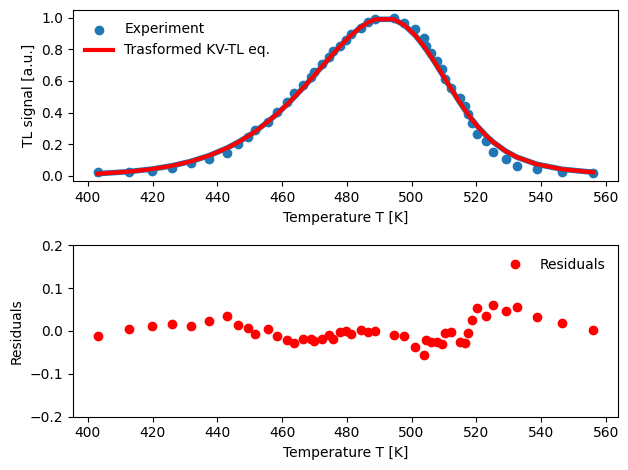

In [4]:
# Deconvolution of alumina TL using the transformed KV-TL eqt
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable 
import warnings
warnings.filterwarnings("ignore")
from scipy.special import wrightomega
import requests

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/aluminaTLshort.TXT'
response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0]+273, data[:, 1] 
y_data=y_data/max(y_data)

kB=8.617E-5
Imax=max(y_data)
Tmx=x_data[np.argmax(y_data)]

def W_func(T,R, E, c,Tmax):
    F=kB*(T**2.0)*np.exp(-E/(kB*T))*(1-2*kB*T/E)/E
    Fm=kB*(Tmax**2.0)*np.exp(-E/(kB*Tmax))*(1-2*kB*Tmax/E)/E
    a=kB*Tmax**2.0*(1-1.05*R**1.26)
    Z=R/(1-R)-np.log((1-R)/R)+(F*E*np.exp(E/(kB*Tmax)))/a
    Zm=R/(1-R)-np.log((1-R)/R)+(Fm*E*np.exp(E/(kB*Tmax)))/a
    argW=wrightomega(Z)
    argWm=wrightomega(Zm) 
    return Imax*np.exp(-E/(kB*T)*(Tmax-T)/Tmax)*\
        	(argWm+argWm**2.0)/(argW+argW**2.0)  


params,cov=optimize.curve_fit(W_func,x_data,y_data,\
p0=(.5,1,10,Tmx),bounds=((.1,.9,1e-4,Tmx-5),(.9,1.3,1e4,Tmx+5)))
plt.subplot(2,1, 1)
plt.plot(x_data, W_func(x_data, *params),'-',linewidth=4)
plt.scatter(x_data, y_data, label='Experiment')
plt.plot(x_data, W_func(x_data, *params),
c='r',linewidth=3, label='Trasformed KV-TL eq.')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]')
plt.xlabel(r'Temperature T [K]')
plt.subplot(2, 1, 2)
plt.plot(x_data,W_func(x_data, *params)-\
y_data,'o',c='r',linewidth=2,label='Residuals')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals')
plt.xlabel(r'Temperature T [K]')
plt.ylim(-.2,.2)
plt.tight_layout()
R, E, c, Tmax=[round(params[x],2) for x in range(4)]
dR, dE, dc, dTmax=[round(np.sqrt(cov[x][x]),2) for x in range(4)]
res=W_func(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),1)
myTable = PrettyTable([ "R", "dR","E(eV)","dE(eV)"]) 
myTable.add_row([R,dR,E,dE])
print("FOM=",FOM," %")
print(myTable)
plt.show()